In [1]:
import os
os.environ['KAGGLE_USERNAME'] = '*'
os.environ['KAGGLE_KEY'] = '*'

In [2]:
!kaggle datasets download -d muhammadkhalid/sign-language-for-numbers

 93% 45.0M/48.1M [00:01<00:00, 41.4MB/s]
100% 48.1M/48.1M [00:01<00:00, 28.5MB/s]


In [3]:
!unzip sign-language-for-numbers.zip

Streaming output truncated to the last 5000 lines.
  inflating: Sign Language for Numbers/7/seven_549.jpg  
  inflating: Sign Language for Numbers/7/seven_55.jpg  
  inflating: Sign Language for Numbers/7/seven_550.jpg  
  inflating: Sign Language for Numbers/7/seven_551.jpg  
  inflating: Sign Language for Numbers/7/seven_552.jpg  
  inflating: Sign Language for Numbers/7/seven_553.jpg  
  inflating: Sign Language for Numbers/7/seven_554.jpg  
  inflating: Sign Language for Numbers/7/seven_555.jpg  
  inflating: Sign Language for Numbers/7/seven_556.jpg  
  inflating: Sign Language for Numbers/7/seven_557.jpg  
  inflating: Sign Language for Numbers/7/seven_558.jpg  
  inflating: Sign Language for Numbers/7/seven_559.jpg  
  inflating: Sign Language for Numbers/7/seven_56.jpg  
  inflating: Sign Language for Numbers/7/seven_560.jpg  
  inflating: Sign Language for Numbers/7/seven_561.jpg  
  inflating: Sign Language for Numbers/7/seven_562.jpg  
  inflating: Sign Language for Numbers/

In [4]:
import os
import random
import shutil

data_dir = "/content/Sign Language for Numbers"
train_dir = "/content/train"
val_dir = "/content/validation"
test_dir = "/content/test"

# Create directories for train, validation, and test sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    

    train_subdir = os.path.join(train_dir, folder_name)
    val_subdir = os.path.join(val_dir, folder_name)
    test_subdir = os.path.join(test_dir, folder_name)
    os.makedirs(train_subdir, exist_ok=True)
    os.makedirs(val_subdir, exist_ok=True)
    os.makedirs(test_subdir, exist_ok=True)
    

    file_list = os.listdir(folder_path)
    random.shuffle(file_list)
    
    num_files = len(file_list)
    num_train = int(0.7 * num_files)
    num_val = int(0.1 * num_files)
    num_test = int(0.2 * num_files)
    
    train_files = file_list[:num_train]
    val_files = file_list[num_train:num_train+num_val]
    test_files = file_list[num_train+num_val:num_train+num_val+num_test]
    for filename in train_files:
        src_path = os.path.join(folder_path, filename)
        dst_path = os.path.join(train_subdir, filename)
        shutil.copyfile(src_path, dst_path)
    
    for filename in val_files:
        src_path = os.path.join(folder_path, filename)
        dst_path = os.path.join(val_subdir, filename)
        shutil.copyfile(src_path, dst_path)
    
    for filename in test_files:
        src_path = os.path.join(folder_path, filename)
        dst_path = os.path.join(test_subdir, filename)
        shutil.copyfile(src_path, dst_path)


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
learning_rate = 0.001
num_epochs = 15
batch_size = 64

In [8]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [9]:
train_dataset = ImageFolder('/content/train', transform=transforms)
validation_dataset = ImageFolder('/content/validation', transform=transforms)
test_dataset = ImageFolder('/content/test', transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
import torchvision as torchvision
model = torchvision.models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, 11).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 49.7MB/s]


In [11]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

for epoch in range(num_epochs):
    running_training_loss = 0.0
    running_training_accuracy = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)  
        labels = labels.to(device) 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()
        if (i+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
        _, preds = torch.max(outputs, 1)
        running_training_accuracy += torch.sum(preds == labels.data)
    
    epoch_training_loss = running_training_loss / len(train_loader)
    epoch_training_accuracy = running_training_accuracy / len(train_loader.dataset)
    training_loss.append(epoch_training_loss)
    training_accuracy.append(epoch_training_accuracy)
    
    running_validation_loss = 0.0
    running_validation_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_loader):
            inputs = inputs.to(device)  
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_validation_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_validation_accuracy += torch.sum(preds == labels.data)
    
    epoch_validation_loss = running_validation_loss / len(validation_loader)
    epoch_validation_accuracy = running_validation_accuracy / len(validation_loader.dataset)
    validation_loss.append(epoch_validation_loss)
    validation_accuracy.append(epoch_validation_accuracy)
    
    print('Epoch [{}/{}], Training Loss: {}, Training Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'
          .format(epoch+1, num_epochs, epoch_training_loss, epoch_training_accuracy, epoch_validation_loss, epoch_validation_accuracy))

Epoch [1/15], Step [50/181], Loss: 1.524193525314331
Epoch [1/15], Step [100/181], Loss: 0.7885401844978333
Epoch [1/15], Step [150/181], Loss: 0.6544177532196045
Epoch [1/15], Training Loss: 1.1983382105827332, Training Accuracy: 0.6596536636352539, Validation Loss: 0.417868214731033, Validation Accuracy: 0.9084848761558533
Epoch [2/15], Step [50/181], Loss: 0.3178492784500122
Epoch [2/15], Step [100/181], Loss: 0.25811901688575745
Epoch [2/15], Step [150/181], Loss: 0.2201208919286728
Epoch [2/15], Training Loss: 0.25879724924735603, Training Accuracy: 0.9407792091369629, Validation Loss: 0.15421095934624857, Validation Accuracy: 0.9709091186523438
Epoch [3/15], Step [50/181], Loss: 0.15138813853263855
Epoch [3/15], Step [100/181], Loss: 0.11101071536540985
Epoch [3/15], Step [150/181], Loss: 0.1854485720396042
Epoch [3/15], Training Loss: 0.1215191040990761, Training Accuracy: 0.9736796021461487, Validation Loss: 0.09968777677903955, Validation Accuracy: 0.9781818389892578
Epoch [4/

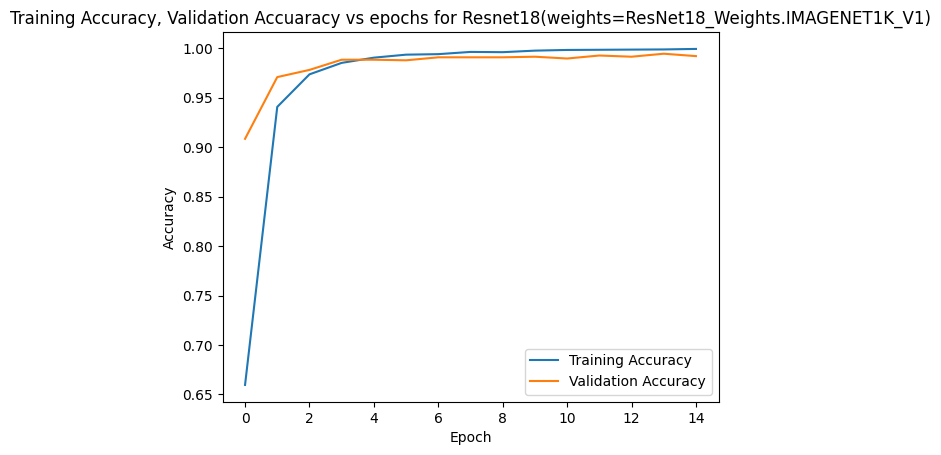

In [12]:
training_accuracy_tensor = torch.tensor(training_accuracy)
validation_accuracy_tensor = torch.tensor(validation_accuracy)

plt.plot(training_accuracy_tensor.to('cpu'), label='Training Accuracy')
plt.plot(validation_accuracy_tensor.to('cpu'), label='Validation Accuracy')
plt.title('Training Accuracy, Validation Accuaracy vs epochs for Resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Test Accuracy: 0.9960606060606061


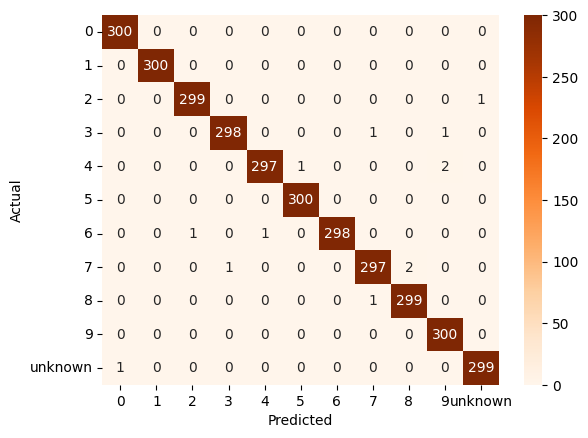

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      0.99      0.99       300
           4       1.00      0.99      0.99       300
           5       1.00      1.00      1.00       300
           6       1.00      0.99      1.00       300
           7       0.99      0.99      0.99       300
           8       0.99      1.00      1.00       300
           9       0.99      1.00      1.00       300
     unknown       1.00      1.00      1.00       300

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



In [13]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_labels = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.tolist())
        test_labels.extend(labels.tolist())

test_acc = accuracy_score(test_labels, test_preds)
print('Test Accuracy: {}'.format(test_acc))

target_names = list(train_dataset.class_to_idx.keys())
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, cmap='Oranges', fmt='g', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_labels, test_preds, target_names=target_names))
